## Рассуждения на начало проекта

Проект по предсказанию целевого признака "будет ли клиент совершать покупки в следующие 90 дней" на основе данных о:

Покупках:
- client_id
- Количество товара
- Цена
- Категория
- Дата
- Рассылка

Рассылках:
- Рекламная компания
- client_id
- Рассылка
- Реакция на рассылку
- Канал рассылки
- Дата
- Дата и Время

Целевой переменной:
- client_id
- target

Рекламных компаниях:
- Дата
- Рекламная компания
- Количество реакций на рассылку
- Количество client_id для каждой реакции

Рекламных компаниях по каналам рассылки:
- Дата
- Рекламная компания
- Количество реакций на рассылку по каналам
- Количество client_id по каналам рассылки


В ходе проекта нужно:
- найти полезные признаки
- классифицировать пользователей по поведению
- максимизировать метрику ROC-AUC
- протестировать полученную модель


Не все признаки кажутся полезными:
- Дата и время. Дата может нам показать нам клиентскую активность по дням, благодаря чему мы можем видеть сезонность и реакцию на рассылки. Так как у нас нет отдельно времени покупок, то время рекламной рассылки нам не даёт дополнительной информации
- Рекламная компания. Если мы знаем после какой конкретной рассылки клиент совершил покупку, знать рекламную компанию уже не обязательно. Только если рассылка по одной компании проводилась множество раз и после множественной рассылки пользователь захотел совершить покупку, но это звучит маловероятно

В качестве проверки гипотезы используем permutation_importance > 0.

Некоторые признаки выглядят зависимыми:
- Дата полностью зависит от Дата и время
- Количество товара связано с Ценой
- Цена связана с Категорией
- Категория связана с Рассылкой
- Рассылка связана с Рекламной компанией, Реакцией на рассылку и Каналами рассылки 

В качестве проверки гипотезы используем корреляцию более 0,85 и VIF более 10, это может быть основанием для удаления.

## Настройка окружения

In [1]:
# !pip install catboost -q

In [2]:
# !pip install optuna -q

In [3]:
# !pip install optuna-integration[sklearn] -q

In [ ]:

import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance

from catboost import CatBoostRegressor


import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import (
    IntDistribution, 
    FloatDistribution, 
    CategoricalDistribution
)

import ast


## Просмотр данных

In [5]:
purchases = pd.read_csv(r"C:\Users\Юра\Downloads\apparel-purchases.csv")

In [6]:
purchases.head(1)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d


In [7]:
def what_a_data(data):
    return pd.DataFrame({
        'null': data.isnull().sum(),
        'null_proportion': 100 * data.isnull().sum() / len(data),
        'dtypes': data.dtypes,
        'nunique': data.nunique(),
        'first_not_null': data.apply(lambda col: col[col.first_valid_index()] if col.first_valid_index() is not None else None),
        'mode': data.mode().iloc[0],
        'mode_frequency': data.apply(lambda col: col.value_counts().max() / len(col))
    })

In [8]:
what_a_data(purchases)

,null,null_proportion,dtypes,nunique,first_not_null,mode,mode_frequency
client_id,0,0.0,int64,49849,1515915625468169594,1515915625853312319,0.001711
quantity,0,0.0,int64,16,1,1,0.995623
price,0,0.0,float64,3642,1999.0,999.0,0.050606
category_ids,0,0.0,object,933,"['4', '28', '57', '431']","['4', '28', '57', '431']",0.042659
date,0,0.0,object,642,2022-05-16,2022-11-11,0.026062
message_id,0,0.0,object,50204,1515915625468169594-4301-627b661e9736d,1515915625489095763-6251-6311b13a4cf78,0.001805


В данных отсутствуют пропуски (null_proportion=0).

client_id: Уникальные значения (nunique=49.8k), распределены равномерно (частота моды всего 0.17%).

quantity: Сильный перекос — 99.56% значений = 1.

price: Мода = 999.0 (5% случаев), но есть разнообразие (3.6k уникальных значений). 

category_ids: Чаще всего встречается список ['4', '28', '57', '431'] (4.27%). Сложный тип данных, его следует разбить

date: Самые частые даты — 2022-11-11 (2.6%) и 2022-05-16. Требуется приведение типов

In [9]:
purchases.describe()

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459458e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


Явных аномалий нет

In [10]:
purchases['category_ids'] = purchases['category_ids'].apply(ast.literal_eval)

In [11]:
purchases[purchases['category_ids'].apply(len) == 3]['category_ids'].apply(tuple).unique()

array([('4', '44', '428'), ('4', '44', '1594'), ('4', '44', '989'),
       ('4', '44', '489'), ('4', '44', '430'), ('4', '44', '501'),
       ('4', '44', '491'), ('4', '44', '1097'), ('4', '44', '490'),
       ('4', '44', '493'), ('4', '44', '1571'), ('4', '44', '549'),
       ('4', '1822', '499'), ('4', '30', '503'), ('4', '44', '1564'),
       ('4', '44', '492'), ('4', '44', '528'), ('4', '44', '1381'),
       ('4', '44', '494'), ('4', '44', '1600'), ('5562', '5597', '5782'),
       ('4', '29', '503')], dtype=object)

In [12]:
purchases['cat1'] = purchases['category_ids'].apply(
    lambda x: x[0] if len(x) > 0 else float('nan')
).astype('float32')

purchases['cat2'] = purchases['category_ids'].apply(
    lambda x: x[1] if len(x) > 1 else float('nan')
).astype('float32')

purchases['cat3'] = purchases['category_ids'].apply(
    lambda x: x[2] if len(x) > 2 else float('nan')
).astype('float32')

purchases['cat2'] = purchases['cat2'] + purchases['cat1'] * (1 + purchases['cat2'].max())
purchases['cat3'] = purchases['cat3'] + purchases['cat2'] * (1 + purchases['cat3'].max())

Создадим колонки с уникальными идентификаторами комбинаций

In [13]:
purchases = purchases.drop('category_ids', axis=1)

what_a_data(purchases)

,null,null_proportion,dtypes,nunique,first_not_null,mode,mode_frequency
client_id,0,0.000000,int64,49849,1515915625468169594,1515915625853312319,0.001711
quantity,0,0.000000,int64,16,1,1,0.995623
price,0,0.000000,float64,3642,1999.0,999.0,0.050606
date,0,0.000000,object,642,2022-05-16,2022-11-11,0.026062
message_id,0,0.000000,object,50204,1515915625468169594-4301-627b661e9736d,1515915625489095763-6251-6311b13a4cf78,0.001805
cat1,6843,3.384139,float32,8,4.0,4.0,0.556744
cat2,6843,3.384139,float32,26,24268.0,24268.0,0.396339
cat3,6843,3.384139,float32,93,153131136.0,212718632960.0,0.151295


In [14]:
purchases['date'] = pd.to_datetime(purchases['date'])
global_max_date = purchases['date'].max() + pd.Timedelta(days=1)

agg_df =  purchases.groupby('client_id').agg(
    sum_quantity = ('quantity','sum'),
    mean_price   = ('price', 'mean'),
    last_date    = ('date', 'max'),
    n_messages   = ('message_id', 'nunique')
).reset_index()


Для каждого клиента найдём:

- сумму количества покупок

- среднюю цену товаров

- количество реализованных рекламных сообщений за 90 дней

- количество дней с последней покупки

- количество покупок за 90 дней

In [15]:
agg_df['days_since_last'] = (global_max_date - agg_df['last_date']).dt.days

In [16]:
cutoff_date = global_max_date - pd.Timedelta(days=90)
recent_counts = (
    purchases[purchases['date'] >= cutoff_date]
    .groupby('client_id')
    .size()
    .reset_index(name='last_90_days_count')
)

agg_df = agg_df.merge(recent_counts, on='client_id', how='left')
agg_df['last_90_days_count'] = agg_df['last_90_days_count'].fillna(0)

In [17]:
def most_frequent(x):
    return x.mode().iloc[0] if not x.mode().empty else None

cat_agg = purchases.groupby('client_id').agg(
    cat1_mode = ('cat1', most_frequent),
    cat3_mode = ('cat3', most_frequent)
).reset_index()

agg_df = agg_df.merge(cat_agg, on='client_id', how='left')

Оставим идентификаторы для любимой первой(поверхностной) категории и любимой третей(конечной)

In [18]:
agg_df = agg_df.drop(columns=['last_date'])
agg_df.head(1)

,client_id,sum_quantity,mean_price,n_messages,days_since_last,last_90_days_count,cat1_mode,cat3_mode
0,1515915625468060902,7,999.0,1,631,0.0,4.0,153124944.0


In [19]:
agg_df['cat3_mode'].nunique()

89

Просмотр датасета коммуникаций

In [20]:
messages = pd.read_csv(r"C:\Users\Юра\Downloads\apparel-messages.csv")

In [21]:
messages.head(1)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20


In [22]:
what_a_data(messages)

,null,null_proportion,dtypes,nunique,first_not_null,mode,mode_frequency
bulk_campaign_id,0,0.0,int64,2709,4439,14272,0.008201
client_id,0,0.0,int64,53329,1515915625626736623,1515915625516327994,0.000243
message_id,0,0.0,object,9061667,1515915625626736623-4439-6283415ac07ea,1515915625489095763-6251-6311b13a4cf78,0.000114
event,0,0.0,object,11,open,send,0.711016
channel,0,0.0,object,2,email,mobile_push,0.589661
date,0,0.0,object,638,2022-05-19,2023-06-10,0.007038
created_at,0,0.0,object,4103539,2022-05-19 00:14:20,2023-12-29 15:20:53,0.000049


Данные снова без пропусков (null_proportion=0).

bulk_campaign_id: 2.7k уникальных значений, слабая концентрация (мода 14272 — всего 0.82%).

client_id: Высокая уникальность (53.3k значений), распределение близко к равномерному (мода ≈ 0.02%).

message_id: Очень много уникальных значений (9M+), частота повторов ничтожна (0.01%). Требыется приведение типов

event: Явный доминирующий статус — send (71.1%), затем open (первое ненулевое значение). Требыется приведение типов

channel: Преобладает email (59%) над mobile_push. Требыется приведение типов

date: Чаще всего встречается 2023-06-10 (0.7%). Требыется приведение типов

created_at: Высокая детализация (4.1M уникальных временных меток), мода = 2023-12-29 15:20:53 (крайне редко). Требыется приведение типов

In [23]:
len(messages)

12739798

In [24]:
messages.duplicated(subset=('created_at', 'date', 'channel', 'message_id', 'client_id', 'bulk_campaign_id')).sum()

np.int64(116980)

Удалим неявные дубликаты

In [25]:
messages.drop_duplicates(subset=('created_at', 'date', 'channel', 'message_id', 'client_id', 'bulk_campaign_id'))

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
...,...,...,...,...,...,...,...
12739793,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40
12739794,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20
12739795,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40
12739796,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40


In [26]:
messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [27]:
messages['date'] = pd.to_datetime(messages['date'])
cutoff_date = messages["date"].max() + pd.Timedelta(days=1)
recent_cutoff = cutoff_date - pd.Timedelta(days=90)

recent_msgs = (
    messages[messages["date"] >= recent_cutoff]
    .groupby("client_id")
    .size()
    .reset_index(name="n_messages_90d")
)


In [28]:
positive = {"open", "click", "purchase"}

positive_df = messages[messages["event"].isin(positive)]
fav_program = (
    positive_df.groupby(["client_id", "bulk_campaign_id"])
    .size()
    .reset_index(name="n_positive")
    .sort_values(["client_id", "n_positive"], ascending=[True, False])
    .drop_duplicates("client_id")
    .rename(columns={"bulk_campaign_id": "fav_campaign"})
    [["client_id", "fav_campaign"]]
)


Для каждого пользователя ищем любимую компанию по количеству положительных реакций

In [29]:
recent_df = messages[messages["date"] >= recent_cutoff]

pos_rate_90d = (
    recent_df.groupby("client_id")["event"]
    .apply(lambda x: (x.isin(positive)).mean())
    .reset_index(name="pos_rate_90d")
)


Ищем количество положительных реакций за 90 дней

In [30]:
fav_channel = (
    positive_df.groupby(["client_id", "channel"])
    .size()
    .reset_index(name="n_pos_channel")
    .sort_values(["client_id", "n_pos_channel"], ascending=[True, False])
    .drop_duplicates("client_id")
    .rename(columns={"channel": "fav_channel"})
    [["client_id", "fav_channel"]]
)


Ищем любимый канал связи

In [31]:
def daypart(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "day"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

messages["hour"] = pd.to_datetime(messages["created_at"]).dt.hour
positive_df["daypart"] = messages["hour"].apply(daypart)


C:\Users\Юра\AppData\Local\Temp\ipykernel_6496\3677352825.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df["daypart"] = messages["hour"].apply(daypart)


Ищем основное время дня когда человек получает сообщения

In [32]:
fav_daypart = (
    positive_df.groupby(["client_id", "daypart"])
    .size()
    .reset_index(name="n_pos_time")
    .sort_values(["client_id", "n_pos_time"], ascending=[True, False])
    .drop_duplicates("client_id")
    .rename(columns={"daypart": "fav_daypart"})
    [["client_id", "fav_daypart"]]
)


In [33]:
conv = messages.groupby(["client_id", "event"]).size().unstack(fill_value=0)

conv["open_rate"] = conv["open"] / conv["send"].replace(0, 1)
conv["ctr"] = conv["click"] / conv["open"].replace(0, 1)
conv["purchase_rate"] = conv["purchase"] / conv["click"].replace(0, 1)
conv["unsubscribe_rate"] = conv["unsubscribe"] / conv["send"].replace(0, 1)
conv["bounce_rate"] = (conv["hard_bounce"] + conv["soft_bounce"]) / conv["send"].replace(0, 1)
conv["spam_rate"] = conv["hbq_spam"] / conv["send"].replace(0, 1)
conv["complain_rate"] = conv["complain"] / conv["send"].replace(0, 1)

conv = conv.reset_index()


Для каждого пользователя найдём:

- Открываемость рекламы

- Кликабельность 

- Конверсию

- Склонность к отмене подписки

- Склонность к отскоку

- Склонность отправлять сообщения в спам

- Склонность отправлять жалобы

In [34]:
conv = conv.drop(columns=['click', 'close', 'complain', 'hard_bounce', 'hbq_spam',
                        'open', 'purchase', 'send', 'soft_bounce', 'subscribe',
                        'unsubscribe'])

In [35]:
agg_df = agg_df.merge(recent_msgs, on='client_id', how='left')
agg_df = agg_df.merge(fav_program, on='client_id', how='left')
agg_df = agg_df.merge(pos_rate_90d, on='client_id', how='left')
agg_df = agg_df.merge(fav_channel, on='client_id', how='left')
agg_df = agg_df.merge(fav_daypart, on='client_id', how='left')
agg_df = agg_df.merge(conv, on='client_id', how='left')
agg_df

,client_id,sum_quantity,mean_price,n_messages,days_since_last,last_90_days_count,cat1_mode,cat3_mode,n_messages_90d,fav_campaign,pos_rate_90d,fav_channel,fav_daypart,open_rate,ctr,purchase_rate,unsubscribe_rate,bounce_rate,spam_rate,complain_rate
0,1515915625468060902,7,999.000000,1,631,0.0,4.0,153124944.0,28.0,4617.0,0.285714,email,morning,0.277778,0.285714,0.500000,0.007937,0.000000,0.0,0.0
1,1515915625468061003,7,2319.285714,1,409,0.0,4.0,153131328.0,18.0,12566.0,0.111111,email,day,0.032468,1.200000,0.166667,0.000000,0.000000,0.0,0.0
2,1515915625468061099,1,299.000000,1,641,0.0,4.0,153131360.0,29.0,9945.0,0.034483,mobile_push,day,0.237209,0.156863,0.000000,0.000000,0.009302,0.0,0.0
3,1515915625468061100,2,1049.000000,1,7,2.0,4.0,153126592.0,131.0,14280.0,0.473282,mobile_push,morning,0.610487,0.006135,1.000000,0.000000,0.007491,0.0,0.0
4,1515915625468061170,19,1768.473684,3,245,0.0,4.0,153131328.0,115.0,11144.0,0.060870,email,morning,0.127572,0.516129,0.187500,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,6,1499.000000,1,1,6.0,2.0,76590992.0,3.0,14648.0,0.666667,mobile_push,day,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0
49845,1515915626010266132,2,909.000000,1,3,2.0,4.0,153125040.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49846,1515915626010439406,2,99.000000,1,1,2.0,4.0,153125008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49847,1515915626010443527,1,1999.000000,1,1,1.0,2.0,76591056.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
target = pd.read_csv(r"C:\Users\Юра\Downloads\apparel-target_binary.csv")

In [37]:
len(target)

49849

In [38]:
df = agg_df.merge(target, on='client_id', how='right')

In [39]:
df = df.drop('client_id', axis=1)

In [40]:
df

,sum_quantity,mean_price,n_messages,days_since_last,last_90_days_count,cat1_mode,cat3_mode,n_messages_90d,fav_campaign,pos_rate_90d,fav_channel,fav_daypart,open_rate,ctr,purchase_rate,unsubscribe_rate,bounce_rate,spam_rate,complain_rate,target
0,7,999.000000,1,631,0.0,4.0,153124944.0,28.0,4617.0,0.285714,email,morning,0.277778,0.285714,0.500000,0.007937,0.000000,0.0,0.0,0
1,7,2319.285714,1,409,0.0,4.0,153131328.0,18.0,12566.0,0.111111,email,day,0.032468,1.200000,0.166667,0.000000,0.000000,0.0,0.0,1
2,1,299.000000,1,641,0.0,4.0,153131360.0,29.0,9945.0,0.034483,mobile_push,day,0.237209,0.156863,0.000000,0.000000,0.009302,0.0,0.0,0
3,2,1049.000000,1,7,2.0,4.0,153126592.0,131.0,14280.0,0.473282,mobile_push,morning,0.610487,0.006135,1.000000,0.000000,0.007491,0.0,0.0,0
4,19,1768.473684,3,245,0.0,4.0,153131328.0,115.0,11144.0,0.060870,email,morning,0.127572,0.516129,0.187500,0.000000,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,6,1499.000000,1,1,6.0,2.0,76590992.0,3.0,14648.0,0.666667,mobile_push,day,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0
49845,2,909.000000,1,3,2.0,4.0,153125040.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
49846,2,99.000000,1,1,2.0,4.0,153125008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
49847,1,1999.000000,1,1,1.0,2.0,76591056.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [41]:
what_a_data(df)

,null,null_proportion,dtypes,nunique,first_not_null,mode,mode_frequency
sum_quantity,0,0.000000,int64,90,7,2,0.276997
mean_price,0,0.000000,float64,11325,999.0,999.0,0.045217
n_messages,0,0.000000,int64,14,1,1,0.879556
days_since_last,0,0.000000,int64,639,631,463,0.018034
last_90_days_count,0,0.000000,float64,48,0.0,0.0,0.896126
cat1_mode,1,0.002006,float64,7,4.0,4.0,0.616301
cat3_mode,1,0.002006,float64,89,153124944.0,153131136.0,0.136853
n_messages_90d,12210,24.493972,float64,275,28.0,27.0,0.012397
fav_campaign,8655,17.362435,float64,1379,4617.0,14272.0,0.045778
pos_rate_90d,12210,24.493972,float64,4265,0.285714,0.0,0.186945


 **1. Основные метрики активности**  

 **`sum_quantity`**   
  - Мода = **2** (27.7% случаев), значит, чаще всего пользователи покупают 2 товара.  
  - Максимальное значение = **90** (редкие случаи крупных покупок).  

 **`mean_price`**  
  - Мода = **999.0** (4.5% случаев), возможно, это стандартная цена или артефакт данных.  
  - Уникальных значений много (**11.3k**), значит, цены сильно варьируются.  

 **`n_messages`**   
  - В **87.96%** случаев пользователи получили **1 сообщение**.  
  - Максимум = **14**, но такие случаи редки.  

 **`days_since_last`**  
  - Чаще всего **463 дня** (1.8%), значит, есть доля "спящих" пользователей.  
  - Максимум = **631 день** (возможно, устаревшие данные).  

 **`last_90_days_count`**  
  - **89.6%** пользователей **неактивны** (`0.0`).  
  - Остальные 10% взаимодействовали с рекламой.  

 **2. Предпочтения пользователей**  

 **`cat1_mode`** (самая частая категория 1)  
  - **61.6%** выбирают категорию **4** (возможно, самая популярная).  
  - Есть пропуски (0.2%).  

 **`cat3_mode`** (самая частая категория 3)    
  - Мода = **153131136.0** (13.7%), но распределение более равномерное.  

 **`fav_campaign`** (любимая рекламная кампания)    
  - **17.4% пропусков** (не все пользователи взаимодействовали).  
  - Чаще всего **14272** (4.6%) — возможно, самая успешная кампания.  

 **`fav_channel`** (предпочитаемый канал)  
  - **email** лидирует (44.6% vs. `mobile_push`).  
  - **17.4% пропусков** (нет данных).  

 **`fav_daypart`** (лучшее время для коммуникации)  
  - **morning** (утро) — 41.5% случаев.  
  - Остальные варианты: `afternoon`, `evening`, `night`.  


 **3. Конверсионные метрики**  

 **`open_rate`**  
  - **15.8% пропусков** (не для всех пользователей есть данные).  
  - Чаще всего **0%** (14.5%), значит, много пользователей не открывают письма.  

**`ctr`**  
  - **0%** в 5.1% случаев — пользователи открыли, но не кликнули.  
  - Максимальные значения до **28.6%** (но редко).  

 **`purchase_rate`**  
  - **0%** в 9% случаев — кликнули, но не купили.  
  - Максимум **50%** (но это редкость).  

 **`unsubscribe_rate`**   
  - **80.1%** пользователей **не отписываются** (`0.0`).  
  - Максимум **0.79%** (редкие случаи).  

 **`bounce_rate`, `spam_rate`, `complain_rate`**  
  - Большинство **0%**, значит, рассылка в целом чистая.  

---

 **4. Целевая переменная (`target`)**  
  - **98.1%** — **0** (не конвертировались).  
  - Только **1.9%** — **1** (конверсия).  
  → **Сильный дисбаланс классов!**  


In [42]:
categorical_for_ohe = ["cat1_mode", "cat3_mode", "fav_channel", "fav_daypart", 'fav_campaign']

count_cols = ["n_messages_90d", "last_90_days_count"]

rate_cols = [
    "open_rate", "ctr", "purchase_rate", "unsubscribe_rate",
    "bounce_rate", "spam_rate", "complain_rate", "pos_rate_90d"
]


def fill_missing(df):
    
    for col in count_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    for col in rate_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())
    
    return df

In [43]:
df = fill_missing(df)

In [44]:
df['cat1_mode'] = df['cat1_mode'].fillna(0).astype('int16')
df['cat3_mode'] = df['cat3_mode'].fillna(0).astype('int64')
df['fav_campaign'] = df['fav_campaign'].fillna(0).astype('int32')
df['fav_channel'] = df['fav_channel'].fillna('0').astype('string')
df['fav_daypart'] = df['fav_daypart'].fillna('0').astype('string')

In [45]:
what_a_data(df)

,null,null_proportion,dtypes,nunique,first_not_null,mode,mode_frequency
sum_quantity,0,0.0,int64,90,7,2,0.276997
mean_price,0,0.0,float64,11325,999.0,999.0,0.045217
n_messages,0,0.0,int64,14,1,1,0.879556
days_since_last,0,0.0,int64,639,631,463,0.018034
last_90_days_count,0,0.0,float64,48,0.0,0.0,0.896126
cat1_mode,0,0.0,int16,8,4,4,0.616301
cat3_mode,0,0.0,int64,90,153124944,153131136,0.136853
n_messages_90d,0,0.0,float64,276,28.0,0.0,0.244940
fav_campaign,0,0.0,int32,1380,4617,0,0.173624
pos_rate_90d,0,0.0,float64,4265,0.285714,0.12,0.246063


## Анализ данных

In [46]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train = pd.concat([X_train, y_train], axis=1)

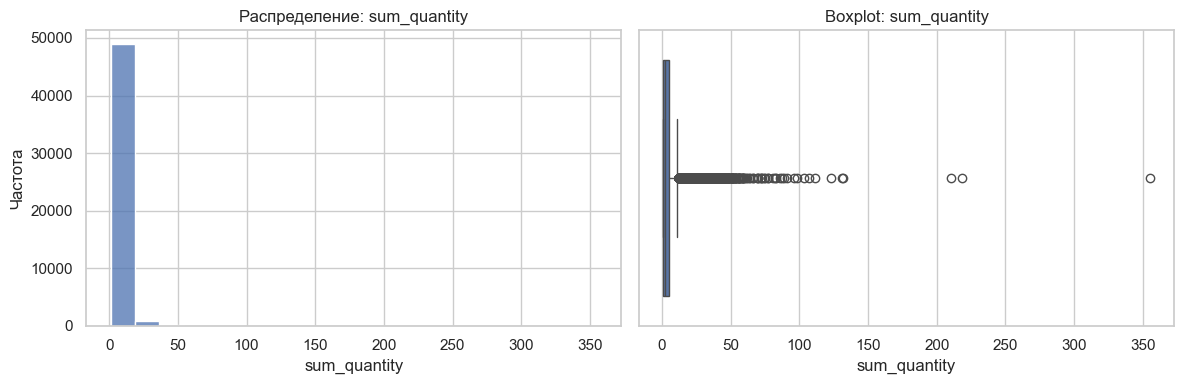

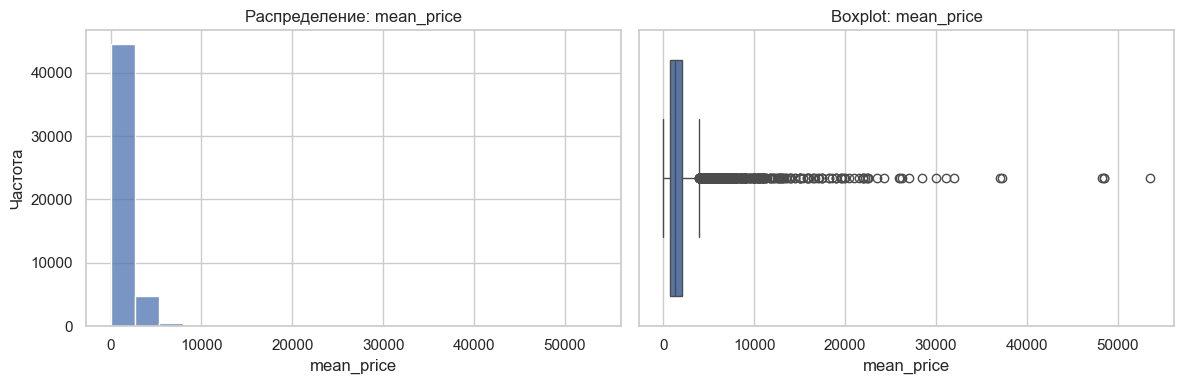

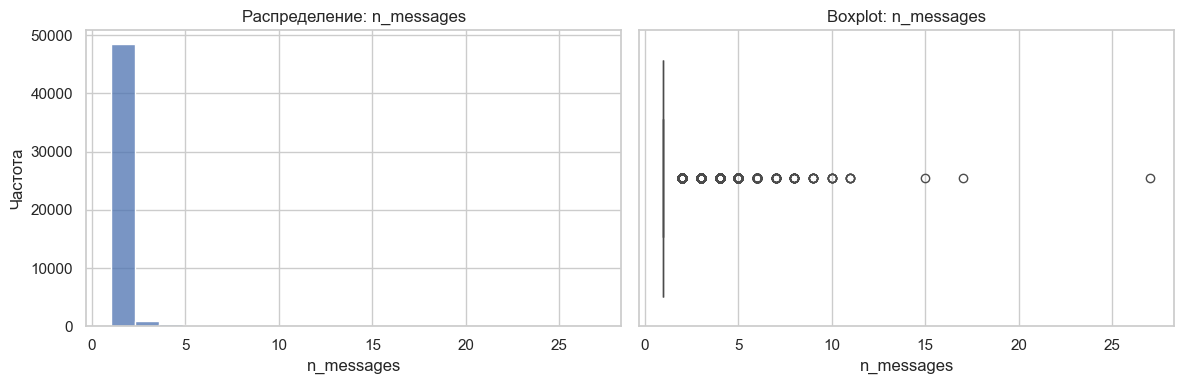

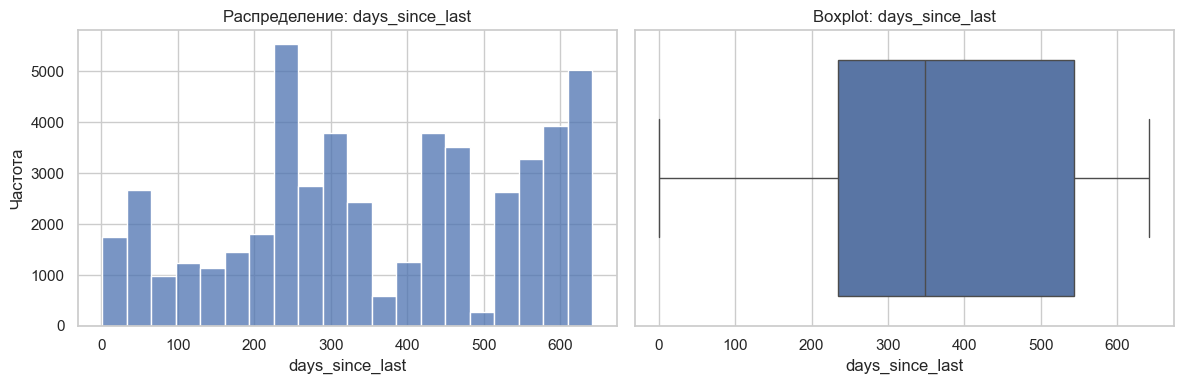

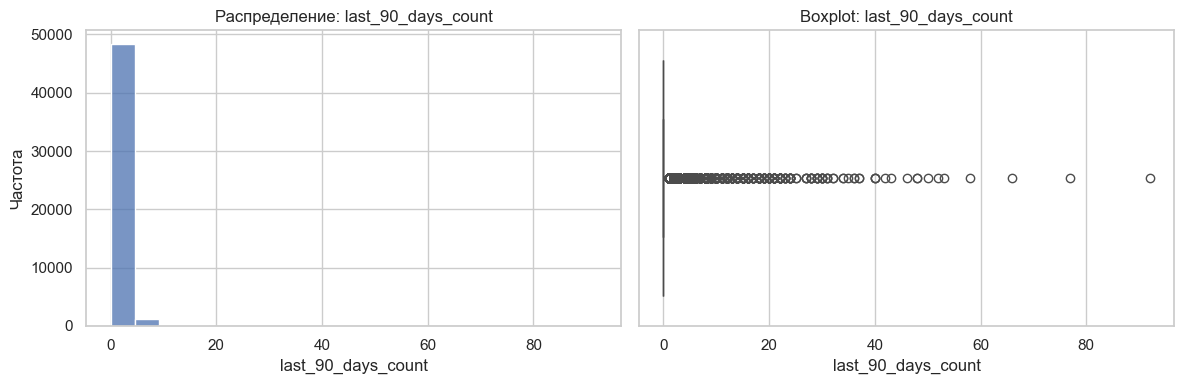

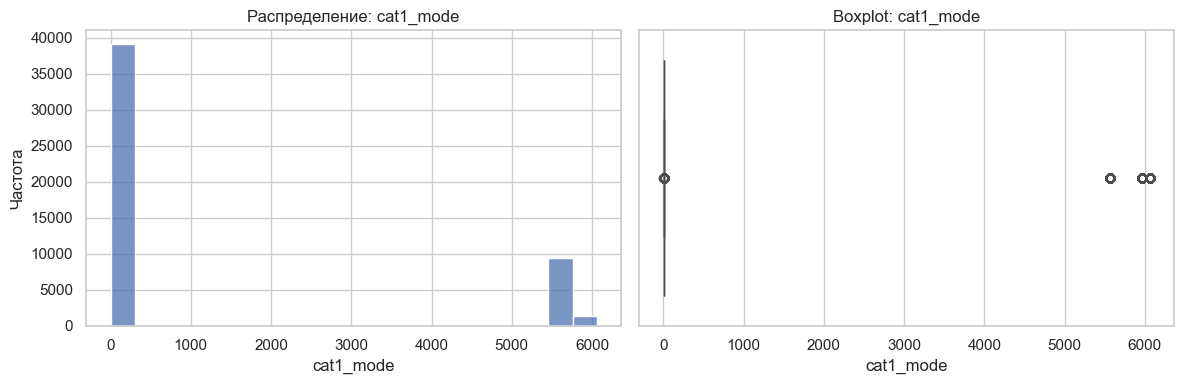

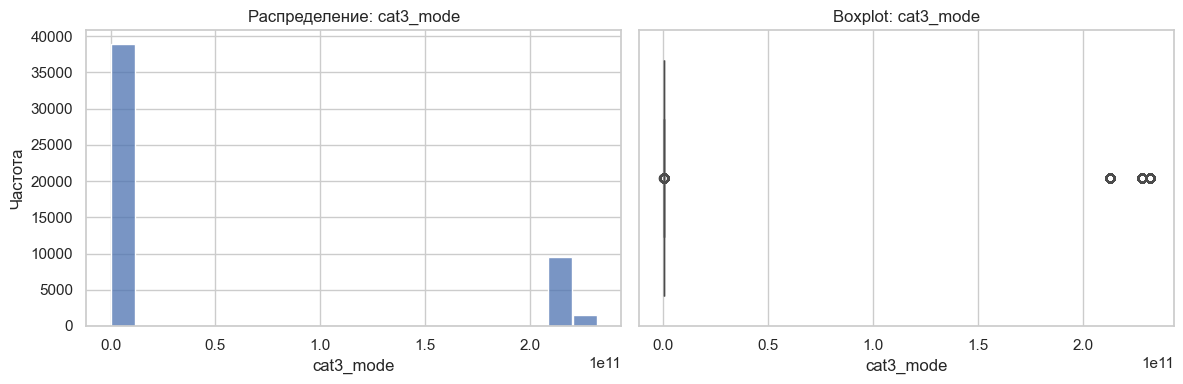

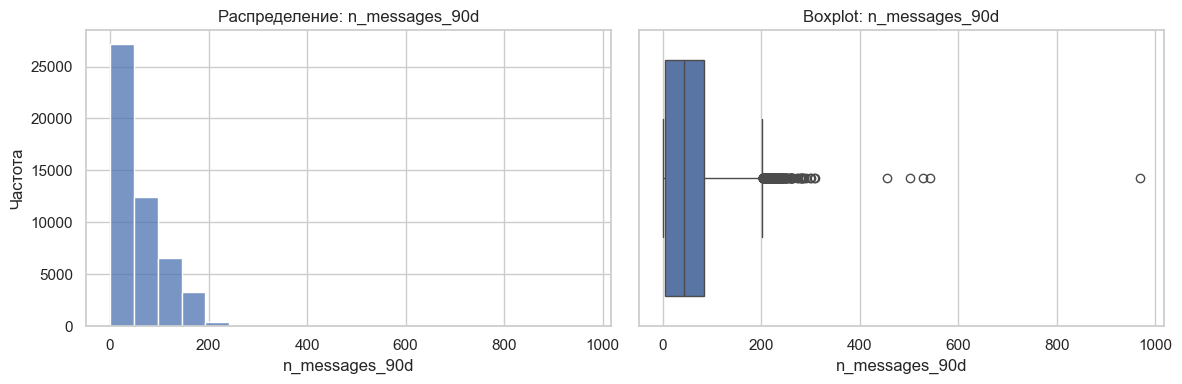

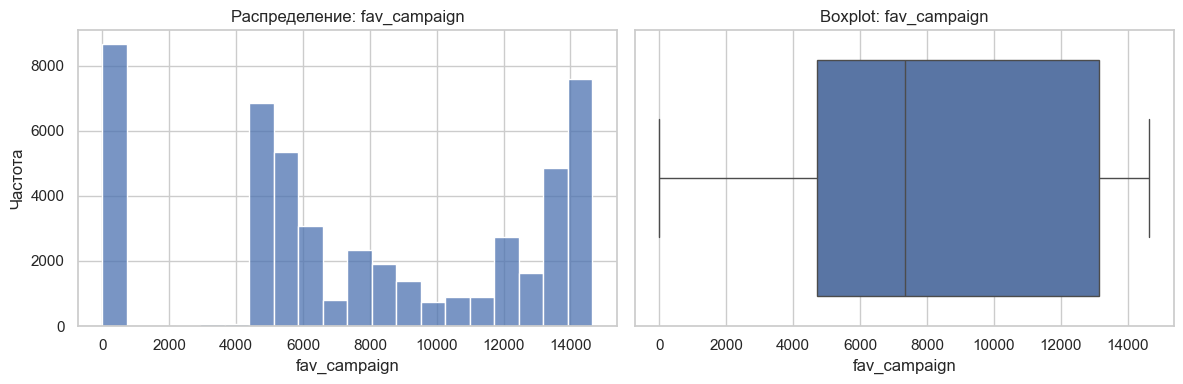

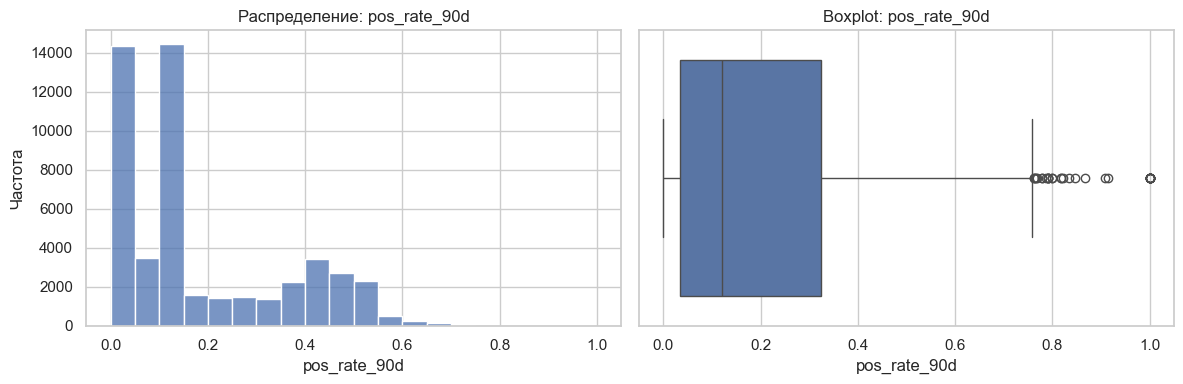

C:\Users\Юра\AppData\Local\Temp\ipykernel_6496\2456812481.py:106: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(data) or pd.api.types.is_object_dtype(data):


Столбец fav_channel неизвестного типа: string — пропущен.
Столбец fav_daypart неизвестного типа: string — пропущен.


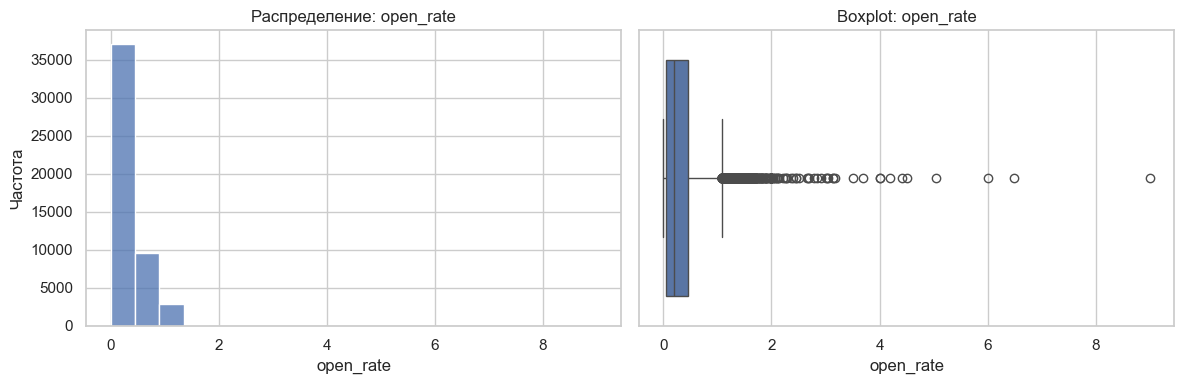

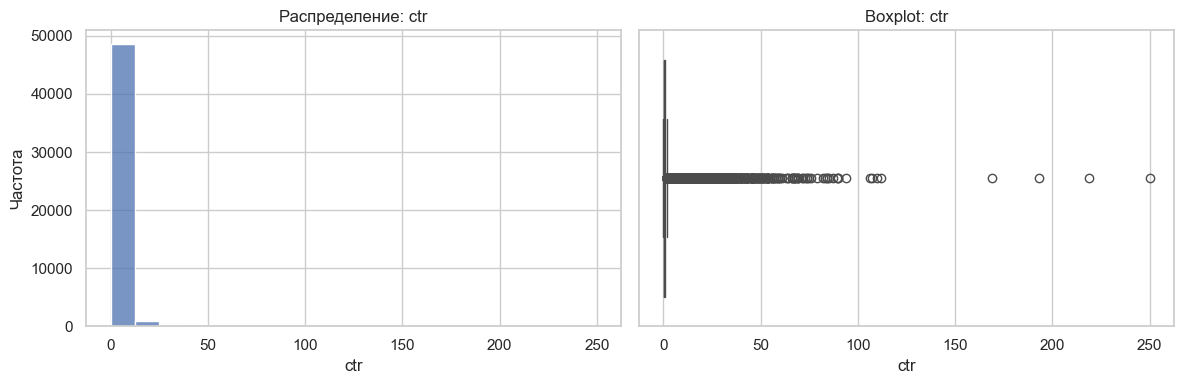

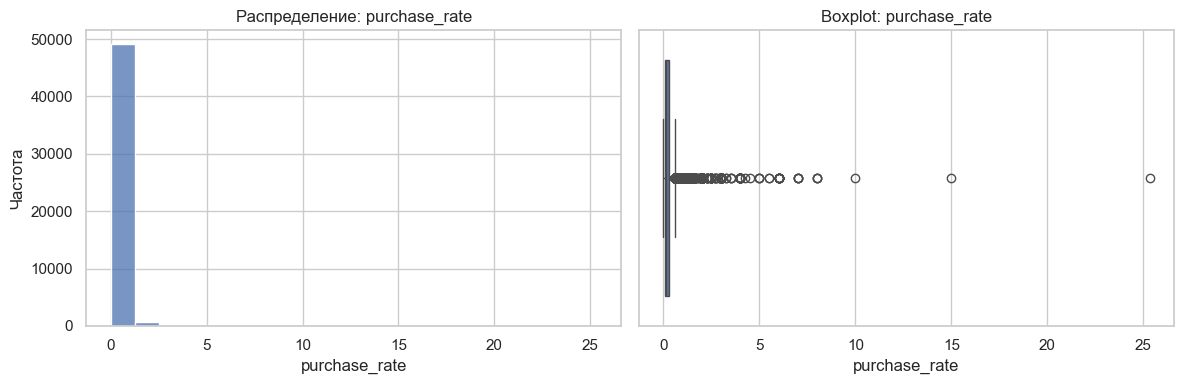

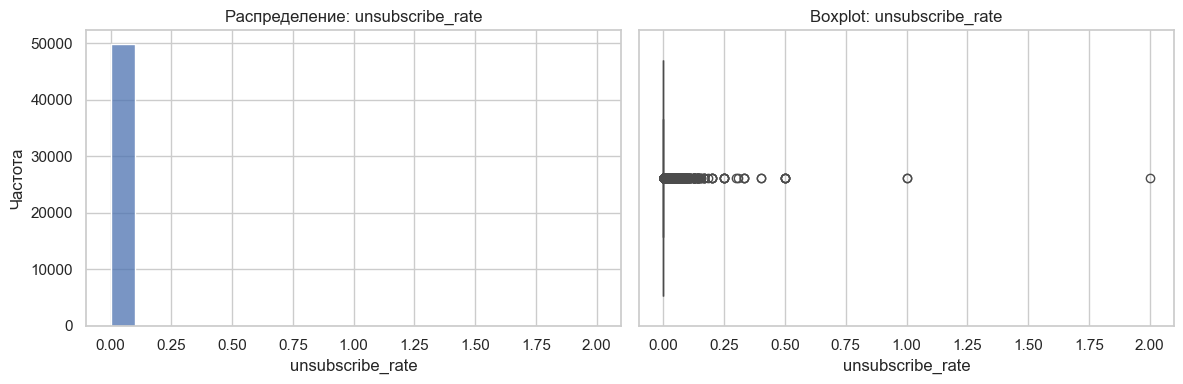

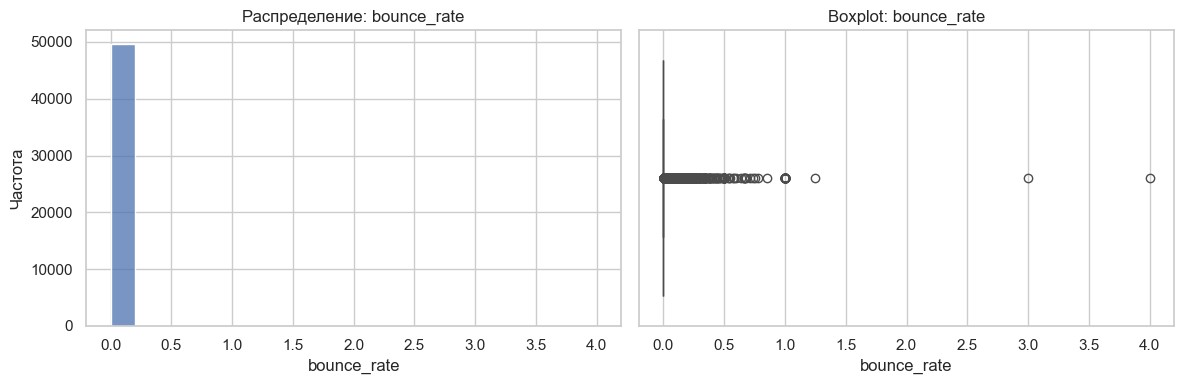

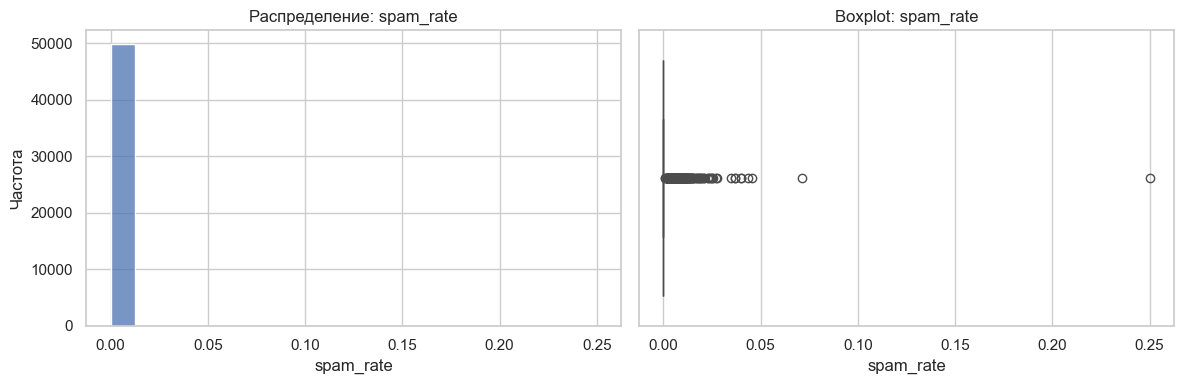

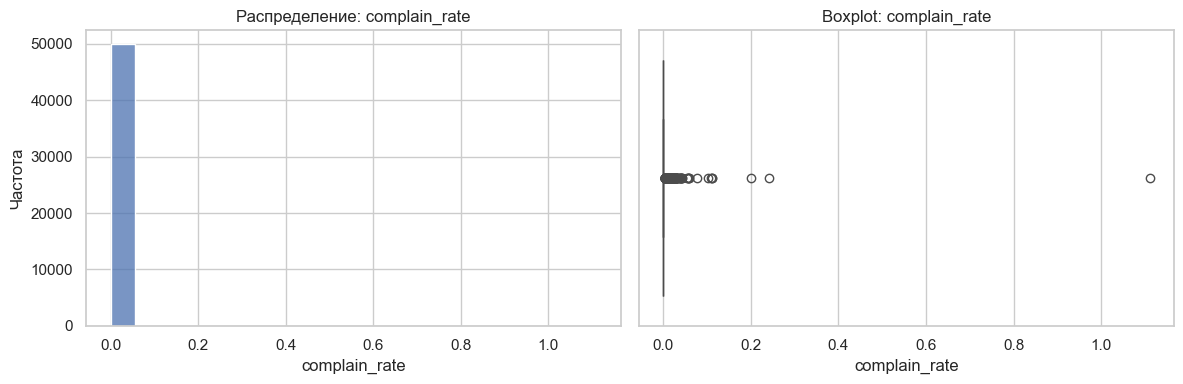

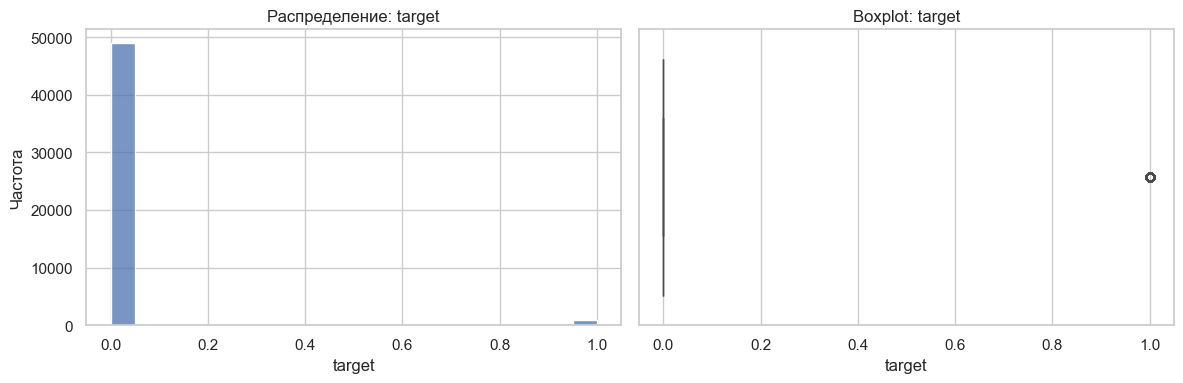

65798

In [47]:
sns.set_theme(style='whitegrid')

def annotate_countplot(ax, total):
    for p in ax.patches:
        height = p.get_height()
        if height == 0: continue
        ax.annotate(
            f'{100 * height / total:.1f}%',
            (p.get_x() + p.get_width() / 2, height),
            ha='center', va='bottom',
            fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points'
        )

def plot_categorical(df, column):
    data = df[column].dropna()
    if data.empty:
        print(f'Столбец {column} пустой или содержит только NaN — пропущен.')
        return

    plt.figure(figsize=(10, 4))
    ax = sns.countplot(
        x=data,
        order=data.value_counts().index,
        color='C0'
    )
    plt.title(f'Распределение: {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.xticks(rotation=45, ha='right')
    annotate_countplot(ax, total=len(data))
    plt.tight_layout()
    plt.show()
    plt.close()

    if data.nunique() == 2:
        plt.figure(figsize=(6, 6))
        value_counts = data.value_counts()
        explode = [0.1] + [0] * (len(value_counts) - 1)
        value_counts.plot.pie(
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette('pastel'),
            wedgeprops={'edgecolor': 'black'},
            explode=explode,
            textprops={'fontsize': 12}
        )
        plt.title(f'Круговая диаграмма: {column}')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
        plt.close()

def plot_numerical(df, column):
    data = df[column].dropna()
    if pd.api.types.is_bool_dtype(data):
        print(f'Boxplot не применяется к булевому признаку {column}. Пропущен.')
        return

    if not pd.api.types.is_numeric_dtype(data):
        print(f'Столбец {column} не числовой — пропущен.')
        return
    if data.empty:
        print(f'Столбец {column} пустой или содержит только NaN — пропущен.')
        return

    if pd.api.types.is_float_dtype(data) and data.nunique() < 20:
        data = data.round(2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data, bins=20, color='C0', ax=axes[0])
    axes[0].set_title(f'Распределение: {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Частота')

    sns.boxplot(x=data, color='C0', ax=axes[1])
    axes[1].set_title(f'Boxplot: {column}')
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()
    plt.close(fig)



def visualize_dataframe(df, exclude_columns=['id']):
    for column in df.columns:
        if column in exclude_columns:
            continue

        unique_vals = df[column].nunique(dropna=True)
        data = df[column]

        if pd.api.types.is_numeric_dtype(data):
            if pd.api.types.is_bool_dtype(data):
                print(f'Столбец {column} логический — визуализируем как категориальный.')
                if unique_vals <= 20:
                    plot_categorical(df, column)
                else:
                    print(f'Столбец {column} с {unique_vals} уникальными значениями — пропущен.')
                continue

            plot_numerical(df, column)

        elif pd.api.types.is_categorical_dtype(data) or pd.api.types.is_object_dtype(data):
            if unique_vals <= 50:
                plot_categorical(df, column)
            else:
                print(f'Столбец {column} с {unique_vals} уникальными значениями — слишком много для категориального анализа.')
        elif pd.api.types.is_datetime64_any_dtype(data):
            print(f'Столбец {column} — datetime. Можно извлечь год/месяц/день, если нужно.')
        else:
            print(f'Столбец {column} неизвестного типа: {data.dtype} — пропущен.')


visualize_dataframe(df) 
gc.collect()


Такие признаки как **`sum_quantity`**, **`mean_price`**, **`n_messages`**, **`last_90_days_count`**, **`cat1_mode`**, **`cat3_mode`**, **`ctr`**, **`purchase_rate`**, **`unsubscribe_rate`**, **`bounce_rate`**, **`spam_rate`**, **`complain_rate`** сосредоточены вокруг одного значения и могут быть малополезны для наших моделей

In [49]:
what_a_data(train)

,null,null_proportion,dtypes,nunique,first_not_null,mode,mode_frequency
sum_quantity,0,0.0,int64,86,2,2,0.276587
mean_price,0,0.0,float64,9532,1749.0,999.0,0.044735
n_messages,0,0.0,int64,14,1,1,0.880338
days_since_last,0,0.0,int64,639,22,463,0.018230
last_90_days_count,0,0.0,float64,44,2.0,0.0,0.895007
cat1_mode,0,0.0,int16,7,4,4,0.618646
cat3_mode,0,0.0,int64,89,153131136,153131136,0.136638
n_messages_90d,0,0.0,float64,269,69.0,0.0,0.244414
fav_campaign,0,0.0,int32,1303,14521,0,0.174503
pos_rate_90d,0,0.0,float64,3973,0.289855,0.12,0.245593


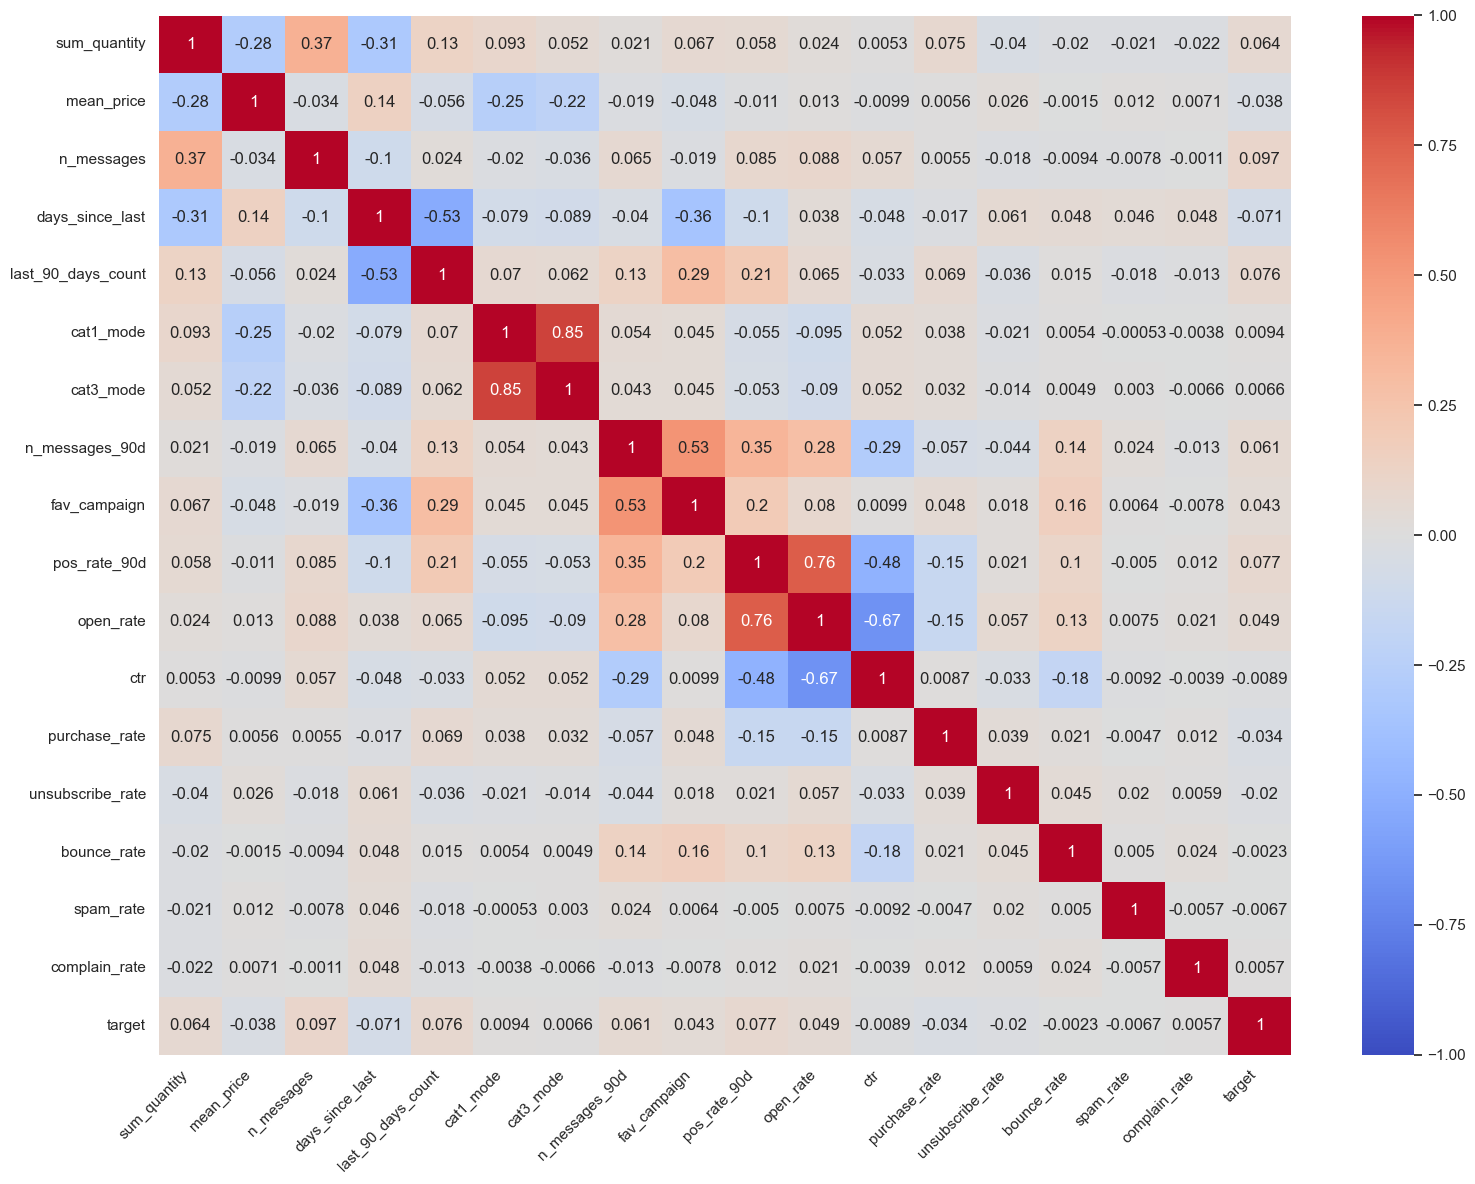

In [50]:
corr_matrix = train[[
    'sum_quantity', 'mean_price', 'n_messages', 'days_since_last',
    'last_90_days_count', 'cat1_mode', 'cat3_mode', 'n_messages_90d',
    'fav_campaign', 'pos_rate_90d', 
    'open_rate', 'ctr', 'purchase_rate', 'unsubscribe_rate', 'bounce_rate',
    'spam_rate', 'complain_rate', 'target'
]].corr(method='spearman')


plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix, 
    annot=True,   
    cmap="coolwarm", 
    center=0,        
    vmin=-1, vmax=1 
)

plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

Любимая компания сильно коррелирует с количеством сообщений, полученных за последние 90 дней.

Открываемость рекламы сильно коррелирует с количеством позитивных реакций за 90 дней

Открываемость отрицательно коррелирует с Кликабельностью как и количество полизитвных реакций за 90 дней

В целом многие признаки никак не связаны между собой, что даёт модели больше информации

In [51]:
def calculate_vif(X):
    X = X.select_dtypes(include=[np.number])
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna(axis=1)
    
    if X.shape[1] == 0:
        raise ValueError("All columns were removed due to NaN or inf values")
    
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

X_train_copy = X_train.copy()
print("NaN values:", X_train_copy.isna().sum().sum())
# print("Inf values:", np.isinf(X_train_copy).sum().sum())

vif_result = calculate_vif(X_train_copy)
print(vif_result)

NaN values: 0
               feature        VIF
0         sum_quantity   1.529277
1           mean_price   0.969877
2           n_messages   1.062667
3      days_since_last   0.728642
4   last_90_days_count   1.253720
5            cat1_mode  24.107142
6            cat3_mode  31.162980
7       n_messages_90d   1.840416
8         fav_campaign   1.182165
9         pos_rate_90d   3.144590
10           open_rate   2.622123
11                 ctr   1.132677
12       purchase_rate   1.079643
13    unsubscribe_rate   1.016378
14         bounce_rate   1.009520
15           spam_rate   1.003455
16       complain_rate   1.000532


cat1_mode и cat3_mode сильно связаны, но все остальные признаки весьма независимы

In [52]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

X_train_train = X_train_train.values
X_train_test = X_train_test.values


model = CatBoostRegressor(
    cat_features=[5, 6, 8, 10, 11],
    iterations=500,
    depth=8,
    learning_rate=0.1,
    loss_function='RMSE',
    verbose=100
)

model.fit(X_train_train, y_train_train)

result = permutation_importance(
    model, X_train_test, y_train_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

importances = pd.Series(result.importances_mean, index=X_train.columns).sort_values(ascending=False)
print(importances)

del X_train_train, X_train_test, y_train_train, y_train_test
gc.collect()

0:	learn: 0.1381622	total: 225ms	remaining: 1m 52s
100:	learn: 0.1295033	total: 8.71s	remaining: 34.4s
200:	learn: 0.1250448	total: 17.9s	remaining: 26.6s
300:	learn: 0.1212223	total: 27s	remaining: 17.9s
400:	learn: 0.1179419	total: 36.2s	remaining: 8.94s
499:	learn: 0.1150803	total: 46.4s	remaining: 0us
open_rate             0.023114
n_messages            0.020243
pos_rate_90d          0.017706
ctr                   0.012462
n_messages_90d        0.012306
days_since_last       0.010028
purchase_rate         0.009062
mean_price            0.006706
last_90_days_count    0.004732
fav_daypart           0.002879
cat1_mode             0.001929
fav_channel           0.001010
bounce_rate           0.000790
cat3_mode             0.000646
unsubscribe_rate      0.000357
spam_rate             0.000275
sum_quantity          0.000233
complain_rate         0.000218
fav_campaign         -0.002487
dtype: float64


31726

Удалим почти бесполезные признаки

In [53]:
X_train = X_train.drop(columns=['bounce_rate', 'cat3_mode', 'unsubscribe_rate', 'spam_rate', 'sum_quantity', 'complain_rate', 'fav_campaign'])
X_test = X_test.drop(columns=['bounce_rate', 'cat3_mode', 'unsubscribe_rate', 'spam_rate', 'sum_quantity', 'complain_rate', 'fav_campaign'])

## Построение модели

In [54]:
what_a_data(X_train)

,null,null_proportion,dtypes,nunique,first_not_null,mode,mode_frequency
mean_price,0,0.0,float64,9532,1749.0,999.0,0.044735
n_messages,0,0.0,int64,14,1,1,0.880338
days_since_last,0,0.0,int64,639,22,463,0.018230
last_90_days_count,0,0.0,float64,44,2.0,0.0,0.895007
cat1_mode,0,0.0,int16,7,4,4,0.618646
n_messages_90d,0,0.0,float64,269,69.0,0.0,0.244414
pos_rate_90d,0,0.0,float64,3973,0.289855,0.12,0.245593
fav_channel,0,0.0,string[python],3,mobile_push,mobile_push,0.444520
fav_daypart,0,0.0,string[python],5,morning,morning,0.413451
open_rate,0,0.0,float64,14163,0.411765,0.202358,0.158755


In [55]:
ohe_columns = ['cat1_mode', 'fav_channel', 'fav_daypart']
num_columns = ['mean_price', 'n_messages', 'days_since_last', 'last_90_days_count', 'n_messages_90d', 'pos_rate_90d', 'open_rate', 'ctr', 'purchase_rate']
preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns),
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_columns)
], remainder='passthrough')  

In [56]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

c:\Users\Юра\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [58]:
models_and_spaces = [
    (
        "LGBM",
        LGBMClassifier(random_state=42, scale_pos_weight=50),
        {
            "n_estimators": IntDistribution(50, 200, step=25),
            "learning_rate": FloatDistribution(0.01, 0.2, log=True),
            "max_depth": IntDistribution(3, 9),
            "num_leaves": IntDistribution(15, 127, log=True),
            "min_child_samples": IntDistribution(5, 20),
        },
    ),
    (
        "Ridge",
        RidgeClassifier(),
        {
            "alpha": FloatDistribution(0.01, 100.0, log=True),
            "solver": CategoricalDistribution(["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]),
            "tol": FloatDistribution(1e-5, 1e-3, log=True)
        }
    ),
    (
        "CatBoost",
        CatBoostClassifier(random_state=42, silent=True),
        {
            "iterations": IntDistribution(50, 200, step=50),
            "learning_rate": FloatDistribution(0.01, 0.2),
            "depth": IntDistribution(4, 8),
        },
    ),
    (
        "GradientBoosting",
        GradientBoostingClassifier(random_state=42),
        {
            "n_estimators": IntDistribution(50, 200),
            "learning_rate": FloatDistribution(0.01, 0.1),
            "max_depth": IntDistribution(3, 5),
            "min_samples_leaf": IntDistribution(1, 4),
        },
    ),
    (
        "LogReg",
        LogisticRegression(max_iter=500, random_state=42),
        {
            "C": FloatDistribution(1e-3, 100, log=True),
            "penalty": CategoricalDistribution(["l1", "l2", "elasticnet"]),
            "solver": CategoricalDistribution(["liblinear", "saga"]),
        },
    ),
    (
        "RandomForest",
        RandomForestClassifier(random_state=42),
        {
            "n_estimators": IntDistribution(50, 300, step=50),
            "max_depth": IntDistribution(3, 15),
            "min_samples_split": IntDistribution(2, 10),
            "min_samples_leaf": IntDistribution(1, 5),
        },
    )
]


results = []

# optuna.logging.set_verbosity(optuna.logging.WARNING)

for name, model, space in models_and_spaces:
    print(f"\nOptimizing {name}...")

    search = OptunaSearchCV(
        estimator=model,
        param_distributions=space,
        scoring='roc_auc',
        cv=3,
        n_trials=30,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    search.fit(X_train_processed, y_train)

    best_score = search.best_score_
    best_estimator = search.best_estimator_
    

    results.append({
        "name": name,
        "score": search.best_score_,
        "params": search.best_params_, 
        "estimator": search.best_estimator_,
    })

results = sorted(results, key=lambda x: -x["score"])

print("\n\n" + "="*50)
print("FINAL MODEL COMPARISON:")
print("="*50)
for i, r in enumerate(results, 1):
    print(f"\n{i}. {r['name']}:")
    print(f"   ROC-AUC: {r['score']:.4f}")
    print("   Best parameters:")
    for param, value in r['params'].items():
        print(f"   - {param}: {value}")

print("\n" + "="*50)
print(f"BEST MODEL: {results[0]['name']} (ROC-AUC: {results[0]['score']:.4f})")
print("="*50)

C:\Users\Юра\AppData\Local\Temp\ipykernel_6496\384073571.py:70: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  search = OptunaSearchCV(
[I 2025-08-18 17:01:39,994] A new study created in memory with name: no-name-c967bcf0-d3d0-4b48-b034-08ae56cc0d51



Optimizing LGBM...


c:\Users\Юра\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Юра\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Юра\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Юра\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Юра\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning

[LightGBM] [Info] Number of positive: 769, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1806
[LightGBM] [Info] Number of data points in the train set: 39879, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019283 -> initscore=-3.929042
[LightGBM] [Info] Start training from score -3.929042

Optimizing Ridge...


[I 2025-08-18 17:01:57,160] Trial 7 finished with value: 0.7389708887190339 and parameters: {'alpha': 79.69656060468168, 'solver': 'cholesky', 'tol': 6.0733619429071135e-05}. Best is trial 7 with value: 0.7389708887190339.
[I 2025-08-18 17:01:57,179] Trial 3 finished with value: 0.7388036168898379 and parameters: {'alpha': 0.03392825770100278, 'solver': 'auto', 'tol': 1.5574151356282583e-05}. Best is trial 7 with value: 0.7389708887190339.
[I 2025-08-18 17:01:57,215] Trial 1 finished with value: 0.7388475006066727 and parameters: {'alpha': 17.539388702158917, 'solver': 'svd', 'tol': 0.00010633490007941876}. Best is trial 7 with value: 0.7389708887190339.
[I 2025-08-18 17:01:57,332] Trial 2 finished with value: 0.7388024229498001 and parameters: {'alpha': 0.013514925364144283, 'solver': 'sparse_cg', 'tol': 5.4781149939405363e-05}. Best is trial 7 with value: 0.7389708887190339.
[I 2025-08-18 17:01:57,540] Trial 5 finished with value: 0.7387149280373619 and parameters: {'alpha': 29.11627


Optimizing CatBoost...


[I 2025-08-18 17:03:09,385] Trial 5 finished with value: 0.7311153015501667 and parameters: {'iterations': 50, 'learning_rate': 0.020707763524997536, 'depth': 4}. Best is trial 5 with value: 0.7311153015501667.
[I 2025-08-18 17:03:09,409] Trial 0 finished with value: 0.7458911084368625 and parameters: {'iterations': 50, 'learning_rate': 0.06427774841226158, 'depth': 5}. Best is trial 0 with value: 0.7458911084368625.
[I 2025-08-18 17:03:09,441] Trial 2 finished with value: 0.7435365509946594 and parameters: {'iterations': 50, 'learning_rate': 0.15235847114652665, 'depth': 6}. Best is trial 0 with value: 0.7458911084368625.
[I 2025-08-18 17:03:16,006] Trial 7 finished with value: 0.7393437644953472 and parameters: {'iterations': 100, 'learning_rate': 0.1708170871462617, 'depth': 5}. Best is trial 0 with value: 0.7458911084368625.
[I 2025-08-18 17:03:18,855] Trial 10 finished with value: 0.7358792171614145 and parameters: {'iterations': 50, 'learning_rate': 0.03968177924906891, 'depth': 


Optimizing GradientBoosting...


[I 2025-08-18 17:05:12,850] Trial 2 finished with value: 0.7412407306256642 and parameters: {'n_estimators': 55, 'learning_rate': 0.043980931882758305, 'max_depth': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7412407306256642.
[I 2025-08-18 17:05:15,775] Trial 0 finished with value: 0.7416253927498845 and parameters: {'n_estimators': 61, 'learning_rate': 0.040774267462232755, 'max_depth': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7416253927498845.
[I 2025-08-18 17:05:41,301] Trial 3 finished with value: 0.7430123433595576 and parameters: {'n_estimators': 117, 'learning_rate': 0.06525754098631861, 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.7430123433595576.
[I 2025-08-18 17:05:43,107] Trial 9 finished with value: 0.732626804620582 and parameters: {'n_estimators': 59, 'learning_rate': 0.025185058533028146, 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.7430123433595576.
[I 2025-08-18 17:05:53,304] Trial 8 finis


Optimizing LogReg...


c:\Users\Юра\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna_integration\sklearn\sklearn.py:394: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
c:\Users\Юра\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2025-08-18 17:10:16,716] Trial 8 failed with parameters: {'C': 0.024102125964262325, 'penalty': 'elasticnet', 'solver': 'liblinear'} because of the following error: The value nan is not acceptable.
[W 2025-08-18 17:10:16,718] Trial 8 failed with value np.float64(nan).
[I 2025-08-18 17:10:17,129] Trial 4 finished with value: 0.665692425440994 and parameters: {'C': 0.0024276666938843586, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 4 with value: 0.665692425440994.
c:\Users\Юра\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna_integ


Optimizing RandomForest...


[I 2025-08-18 17:11:15,848] Trial 0 finished with value: 0.7259779630466348 and parameters: {'n_estimators': 50, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7259779630466348.
[I 2025-08-18 17:11:18,977] Trial 7 finished with value: 0.7284709587393227 and parameters: {'n_estimators': 150, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.7284709587393227.
[I 2025-08-18 17:11:23,702] Trial 2 finished with value: 0.7430550810129466 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.7430550810129466.
[I 2025-08-18 17:11:25,642] Trial 9 finished with value: 0.7339933615252866 and parameters: {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7430550810129466.
[I 2025-08-18 17:11:28,155] Trial 8 finished with value: 0.7408551552042407 and parameters: {'n_e



FINAL MODEL COMPARISON:

1. CatBoost:
   ROC-AUC: 0.7501
   Best parameters:
   - iterations: 150
   - learning_rate: 0.06454567583035091
   - depth: 4

2. GradientBoosting:
   ROC-AUC: 0.7448
   Best parameters:
   - n_estimators: 174
   - learning_rate: 0.055378262360937756
   - max_depth: 3
   - min_samples_leaf: 1

3. RandomForest:
   ROC-AUC: 0.7436
   Best parameters:
   - n_estimators: 300
   - max_depth: 7
   - min_samples_split: 10
   - min_samples_leaf: 5

4. LGBM:
   ROC-AUC: 0.7392
   Best parameters:
   - n_estimators: 75
   - learning_rate: 0.010760229751597197
   - max_depth: 6
   - num_leaves: 16
   - min_child_samples: 18

5. LogReg:
   ROC-AUC: 0.7391
   Best parameters:
   - C: 0.0036338855269518362
   - penalty: l2
   - solver: saga

6. Ridge:
   ROC-AUC: 0.7390
   Best parameters:
   - alpha: 94.78898857609364
   - solver: cholesky
   - tol: 3.926127867643699e-05

BEST MODEL: CatBoost (ROC-AUC: 0.7501)


Лидирует CatBoost (0.7501), хотя отрыв от GradientBoosting (0.7448) и RandomForest (0.7436) совсем небольшой — порядка 0.005.

LGBM, LogReg и Ridge заметно слабее (0.7392–0.7390), фактически вровень.

**CatBoost**

Небольшая глубина (4) и умеренный learning_rate ~0.065 → модель явно не переобучается, держит баланс.

150 итераций мало, но CatBoost часто эффективен даже на коротких деревьях.

Хорошо работает с категориальными фичами — возможно, именно это дало преимущество.

**GradientBoosting**

Классический набор: глубина 3, learning_rate ~0.055, ~174 деревьев.

То есть это “базовый” бустинг, аккуратно настроенный, но без фишек CatBoost.

**RandomForest**

Глубина 7, много деревьев (300), но с min_samples_split=10 и min_samples_leaf=5 → сильное ограничение разрастания деревьев, то есть RF работает очень сглаженно.

Это объясняет близкий к бустингам результат: ансамбль сглаживает шум, но без "градиентного обучения".

**LGBM**

Очень низкий learning_rate (0.0107), при этом мало итераций (75).

Такое сочетание обычно неэффективно: модель просто не успевает "разогнаться". Возможно, стоит докрутить число деревьев.

max_depth=6, num_leaves=16 → довольно ограниченные деревья. Это тоже могло “задушить” модель.

**LogReg** и **Ridge**

Оба сходятся к ~0.739. Это ожидаемо: линейные методы выжимают максимум при текущем наборе признаков.

LogReg выбрала очень маленький C (~0.0036), значит регуляризация сильная → модель почти "сжимает" веса.

Ridge с alpha ~95 тоже жёстко штрафует.

Итог: признаки недостаточно линейно разделимы, линейные модели уперлись в потолок.

In [ ]:
y_pred =  search.best_estimator_.predict_proba(X_test_processed)[:, 1]

roc_auc_score(y_test, y_pred)

0.7624596777630054

Результат даже лучше чем мы ожидали!